# Word2Vec

https://radimrehurek.com/gensim/

In [35]:
import os

from tqdm import tqdm
import pandas as pd

from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

#   my packages
from preProcessing import textProcessing

## Phrases

We are using Gensim Phrases package to automatically detect common phrases (bigrams and trigrams) from a list of sentences.

In [36]:
setLyrics=pd.read_excel(os.path.join("data", "setLyrics.xlsx"))

setLyrics=setLyrics[setLyrics.lyricToken.notnull()]

#Phrases() takes a list of list of words as input
sentence_stream = []
for doc in tqdm(setLyrics.lyricToken):
    sentence_stream.append(doc.split(" "))
print("sentence_stream")


100%|██████████| 114099/114099 [00:04<00:00, 27880.25it/s]

sentence_stream


In [37]:
#Creates the relevant phrases from the list of sentences:
phrases = Phrases(sentence_stream   #The sentences iterable
, min_count=10  #Ignore all words and bigrams with total collected count lower than this value
, progress_per=1000    #Indicates how many words to process before showing/updating the progress
)

INFO - 12:10:21: collecting all words and their counts
INFO - 12:10:21: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:10:21: PROGRESS: at sentence #1000, processed 134839 words and 57032 word types
INFO - 12:10:21: PROGRESS: at sentence #2000, processed 257406 words and 103197 word types
INFO - 12:10:22: PROGRESS: at sentence #3000, processed 386445 words and 138309 word types
INFO - 12:10:22: PROGRESS: at sentence #4000, processed 508809 words and 181055 word types
INFO - 12:10:22: PROGRESS: at sentence #5000, processed 618930 words and 205395 word types
INFO - 12:10:22: PROGRESS: at sentence #6000, processed 734524 words and 229296 word types
INFO - 12:10:23: PROGRESS: at sentence #7000, processed 855364 words and 263153 word types
INFO - 12:10:23: PROGRESS: at sentence #8000, processed 959627 words and 279564 word types
INFO - 12:10:23: PROGRESS: at sentence #9000, processed 1084450 words and 298521 word types
INFO - 12:10:23: PROGRESS: at sentence #10000, p

In [38]:
bigram = Phraser(phrases)
#Transform the corpus based on the bigrams detected:
bigram_sent = bigram[sentence_stream]

INFO - 12:11:06: exporting phrases from Phrases<2589790 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 12:11:16: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<20265 phrases, min_count=10, threshold=10.0> from Phrases<2589790 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 10.44s', 'datetime': '2022-02-20T12:11:16.970918', 'gensim': '4.1.2', 'python': '3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


In [39]:
trigram_sent = Phrases(bigram_sent)

sent = [u'the', u'new', u'york', u'times', u'is', u'a', u'newspaper']
print(trigram_sent[bigram[sent]])

INFO - 12:11:17: collecting all words and their counts
INFO - 12:11:17: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:11:22: PROGRESS: at sentence #10000, processed 1166166 words and 339767 word types
INFO - 12:11:27: PROGRESS: at sentence #20000, processed 2321262 words and 601303 word types
INFO - 12:11:31: PROGRESS: at sentence #30000, processed 3395032 words and 813462 word types
INFO - 12:11:42: PROGRESS: at sentence #40000, processed 5922992 words and 1394677 word types
INFO - 12:11:49: PROGRESS: at sentence #50000, processed 7771786 words and 1717182 word types
INFO - 12:11:54: PROGRESS: at sentence #60000, processed 9013472 words and 1879064 word types
INFO - 12:11:59: PROGRESS: at sentence #70000, processed 10155408 words and 2029774 word types
INFO - 12:12:07: PROGRESS: at sentence #80000, processed 11982454 words and 2279752 word types
INFO - 12:12:14: PROGRESS: at sentence #90000, processed 13801612 words and 2516484 word types
INFO - 12:12:19: PROG

['the', 'new_york_times', 'is', 'a', 'newspaper']


In [40]:
word_freq = defaultdict(int)
for big in bigram_sent:
    for i in big:
        word_freq[i] += 1
len(word_freq)

148319

In [41]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['be', 'not', 'get', 'know', 'like', 'love', 'go', 'oh', '..', 'say']

## Training the model

In [42]:
from time import time  # To time our operations

import multiprocessing
from gensim.models import Word2Vec

In [43]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [44]:
#In this first step, we set up the parameters of the model one-by-one. we don't supply the parameter sentences, and therefore leave the model uninitialized, purposefully.
w2v_model = Word2Vec(min_count=10,  #Ignores all words with total absolute frequency lower than this - (2, 100)
                     window=3,  #The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the right of our target
                     sample=6e-5,   #Dimensionality of the feature vectors
                     alpha=0.03,  #The initial learning rate
                     min_alpha=0.0007,  #Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
                     negative=20,  #If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
                     workers=cores-1  #Use these many worker threads to train the model (=faster training with multicore machines)
                     )

INFO - 12:13:10: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.03)', 'datetime': '2022-02-20T12:13:10.957302', 'gensim': '4.1.2', 'python': '3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


In [45]:
t = time()
#Here it builds the vocabulary from a sequence of sentences and thus initialized the model. With the loggings, We can follow the progress and even more important, the effect of min_count and sample on the word corpus. We noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

#Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them)
w2v_model.build_vocab(bigram_sent, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:13:11: collecting all words and their counts
INFO - 12:13:11: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:13:14: PROGRESS: at sentence #10000, processed 1166166 words, keeping 30713 word types
INFO - 12:13:16: PROGRESS: at sentence #20000, processed 2321262 words, keeping 45677 word types
INFO - 12:13:19: PROGRESS: at sentence #30000, processed 3395032 words, keeping 56120 word types
INFO - 12:13:24: PROGRESS: at sentence #40000, processed 5922992 words, keeping 89644 word types
INFO - 12:13:28: PROGRESS: at sentence #50000, processed 7771786 words, keeping 103427 word types
INFO - 12:13:31: PROGRESS: at sentence #60000, processed 9013472 words, keeping 109377 word types
INFO - 12:13:34: PROGRESS: at sentence #70000, processed 10155408 words, keeping 115150 word types
INFO - 12:13:38: PROGRESS: at sentence #80000, processed 11982454 words, keeping 126747 word types
INFO - 12:13:42: PROGRESS: at sentence #90000, processed 13801612 words, keeping

Time to build vocab: 0.71 mins


In [46]:
t = time()
#The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.
w2v_model.train(bigram_sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:13:53: Word2Vec lifecycle event {'msg': 'training model with 3 workers on 45059 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3 shrink_windows=True', 'datetime': '2022-02-20T12:13:53.948668', 'gensim': '4.1.2', 'python': '3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
INFO - 12:13:55: EPOCH 1 - PROGRESS: at 1.95% examples, 109469 words/s, in_qsize 6, out_qsize 0
INFO - 12:13:56: EPOCH 1 - PROGRESS: at 4.52% examples, 123936 words/s, in_qsize 5, out_qsize 0
INFO - 12:13:57: EPOCH 1 - PROGRESS: at 7.39% examples, 129006 words/s, in_qsize 6, out_qsize 0
INFO - 12:13:58: EPOCH 1 - PROGRESS: at 10.12% examples, 133003 words/s, in_qsize 5, out_qsize 0
INFO - 12:13:59: EPOCH 1 - PROGRESS: at 12.66% examples, 132302 words/s, in_qsize 6, out_qsize 0
INFO - 12:14:00: EPOCH 1 - PROGRESS: at 15.21% examples, 133498 words/s, in_qsize 5, out_qsize 0
INFO - 12:14:01:

Time to train the model: 28.29 mins


In [47]:
#init_sims() will make the model much more memory-efficient
w2v_model.init_sims(replace=True)

<ipython-input-47-a183108f1e1b>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 12:42:11: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


## Exploring the model

Most similar to:

In [48]:
w2v_model.wv.most_similar(positive=["love"])

[('know', 0.7893120646476746),
 ('want', 0.7753010988235474),
 ('need', 0.7718697786331177),
 ('never', 0.7614490389823914),
 ('cause', 0.7601200342178345),
 ('feel', 0.7569148540496826),
 ('not', 0.7437164783477783),
 ('baby', 0.7411006689071655),
 ('ever', 0.7382420301437378),
 ('way', 0.729354202747345)]

In [49]:
w2v_model.wv.most_similar(positive=["war"])

[('battle', 0.678908109664917),
 ('fight', 0.653950572013855),
 ('soldier', 0.64350825548172),
 ('war_war', 0.6134594678878784),
 ('army', 0.5931833982467651),
 ('peace', 0.5879377722740173),
 ('warrior', 0.5862287878990173),
 ('casualty', 0.5828642249107361),
 ('declare_war', 0.5593860149383545),
 ('weapon', 0.5537083148956299)]

Similarities:

In [50]:
w2v_model.wv.similarity("love", 'fight')

0.4766273

In [51]:
w2v_model.wv.similarity("love", 'pain')

0.58805233

In [52]:
w2v_model.wv.similarity("love", 'sex')

0.24982646

In [53]:
w2v_model.wv.similarity("love", 'heaven')

0.48682058

In [54]:
w2v_model.wv.similarity("love", 'hell')

0.30031276

Odd-One-Out:

In [55]:
w2v_model.wv.doesnt_match(['money', 'love', 'war'])

'money'

In [56]:
w2v_model.wv.doesnt_match(['hope', 'love', 'war'])

'war'

Analogy difference:

In [57]:
w2v_model.wv.most_similar(positive=["war", "love"], negative=["fight"], topn=3)

[('true', 0.6023526191711426),
 ('heart', 0.5179215669631958),
 ('need', 0.517336368560791)]

t-SNE visualizations:

In [58]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [59]:
#t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.
#Our goal in this section is to plot our 100 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.
#For that we are going to use t-SNE implementation from scikit-learn.
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

10 Most similar words vs. 8 Random words

C:\Users\w0rk5\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\w0rk5\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


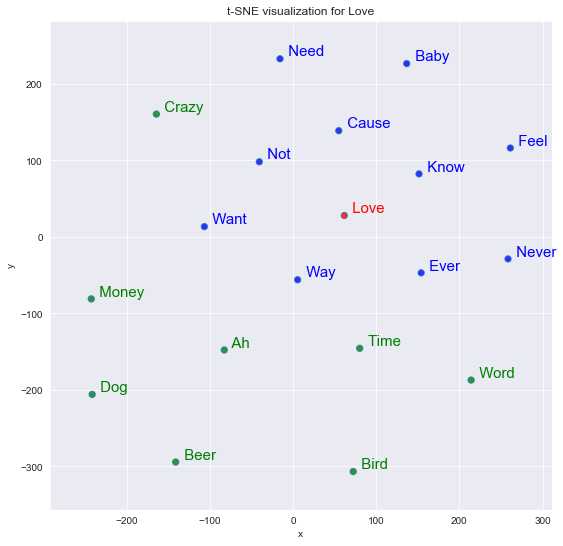

In [60]:
tsnescatterplot(w2v_model, 'love', ['dog', 'bird', 'ah', 'crazy', 'beer', 'money', 'word', 'time'])

10 Most similar words vs. 10 Most dissimilar

C:\Users\w0rk5\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\w0rk5\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


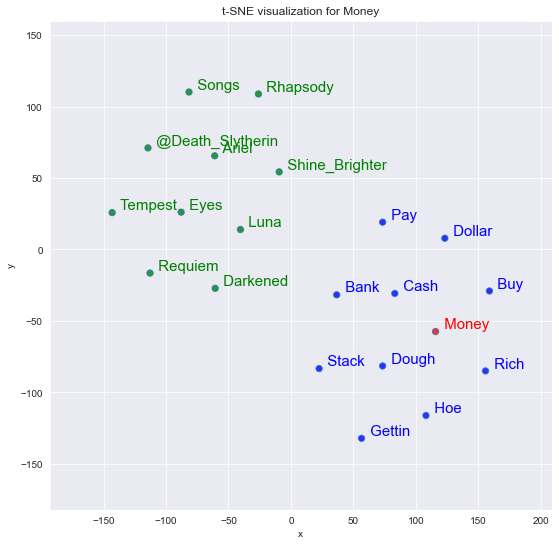

In [61]:
tsnescatterplot(w2v_model, 'money', [i[0] for i in w2v_model.wv.most_similar(negative=["money"])])